OK quantidade de pedidos baseado no horário do dia -> ajuda a entender horários de pico

OK quantida de pedidos por dia da semana -> ajuda a entender demanda por dia da semana

OK pedidos por estado -> ajuda a entender demanda

tempo médio por estado -> ajuda a entender se o tempo de entrega está relacionado com a cidade do estabelecimento

OK meios de pagamentos mais usados para pagar -> serve mais como um insight legal pra mostrar pro cliente

OK separar pedidos por CANCELADO ou FEITO e analisar regiões onde mais ocorreram, horários e etc

tempo médio por driver_type

tempo médio por driver_modal

pedidos por channel type

# Funções

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from math import ceil  # Importar a função ceil

pd.options.display.max_columns=50 
pd.options.display.max_rows=80

In [2]:
def create_multiple_boxplots(data_frame, columns_for_boxplot, titles=None, num_boxplots_per_row=2):
    # Calcular a quantidade;
    num_boxplots = len(columns_for_boxplot)
    num_rows = (num_boxplots + num_boxplots_per_row - 1) // num_boxplots_per_row

    # Criar os subplots
    fig = make_subplots(rows=num_rows, cols=num_boxplots_per_row, subplot_titles=titles)

    # Loop para ir montando todos os gráficos em boxplot
    for idx, column in enumerate(columns_for_boxplot):
        row_idx = idx // num_boxplots_per_row + 1
        col_idx = idx % num_boxplots_per_row + 1

        data = data_frame[column]
        box = go.Box(y=data, name=column)

        fig.add_trace(box, row=row_idx, col=col_idx)

    # Ajustando a forma
    fig.update_layout(height=300*num_rows, showlegend=False)

    # Plotar os gráficos
    fig.show()

In [3]:
def plotar_distribuicoes(data_frame, columns_for_distribution, num_distributions_per_row=2):
    # Calcular a quantidade
    num_distributions = len(columns_for_distribution)
    num_rows = ceil(num_distributions / num_distributions_per_row)

    # Criar os subplots
    fig = make_subplots(rows=num_rows, cols=num_distributions_per_row)

    # Loop para ir montando todos os gráficos de distribuição
    for idx, column in enumerate(columns_for_distribution):
        dados = data_frame[column].dropna()  # Remover valores ausentes

        # Criar o gráfico de histograma
        histogram_data = go.Histogram(x=dados, nbinsx=30, name=f'Histograma - {column}')

        # Adicionar ao subplot
        fig.add_trace(histogram_data,
                      row=(idx // num_distributions_per_row) + 1, col=(idx % num_distributions_per_row) + 1)

    # Atualizar o layout com títulos e legendas adequadas
    for idx, column in enumerate(columns_for_distribution):
        row_idx = (idx // num_distributions_per_row) + 1
        col_idx = (idx % num_distributions_per_row) + 1

        # Adicionar título ao subplot
        fig.update_xaxes(title_text=f'{column}', row=row_idx, col=col_idx)
        fig.update_yaxes(title_text='Quantidade', row=row_idx, col=col_idx)  # Adicionar título ao eixo Y

    # Ajustando a forma
    fig.update_layout(height=300*num_rows, showlegend=False)  # Remover a legenda

    # Plotar os gráficos
    fig.show()

In [4]:
def find_correlated_columns(df, interval):
    """
    Encontra e exibe as correlações entre colunas de um DataFrame.

    Parâmetros:
    - df: DataFrame pandas
    - intervalo de correlação desejado (uma tupla de dois valores)

    Retorna:
    - Lista de tuplas representando pares de colunas correlacionadas.
    """
    correlation_matrix = df.corr(numeric_only=True)
    correlated_columns = []

    # Iterar sobre as combinações de colunas para encontrar correlações
    for i in range(len(correlation_matrix.columns)):
        for j in range(i + 1, len(correlation_matrix.columns)):
            corr = correlation_matrix.iloc[i, j]
            if interval[0] <= abs(corr) <= interval[1]:
                col1 = correlation_matrix.columns[i]
                col2 = correlation_matrix.columns[j]
                correlated_columns.append((col1, col2))
                print(f"Correlação entre {col1} e {col2}: {corr}")

    # Plotar um mapa de calor da matriz de correlação
    plt.figure(figsize=(20, 16))
    sns.heatmap(correlation_matrix, annot=True, cmap='cubehelix_r')
    plt.title('Matriz de Correlação')
    plt.xlabel('Variáveis')
    plt.ylabel('Variáveis')
    plt.show()

    return correlated_columns

In [5]:
def correlacao_com_variavel_alvo(df, target_variable, nivel="forte", top_n=5):
    """
    Imprime as n features com as maiores correlações com uma variável alvo, com base no nível escolhido.

    Parâmetros:
    - df: DataFrame pandas.
    - target_variable: String, nome da variável alvo.
    - nivel: String que define o critério de correlação ("forte", "fraca", etc.).
    - top_n: Número inteiro, quantidade de features a serem impressas.

    Retorna:
    - Nenhum (imprime as correlações).
    """
    correlation_matrix = df.corr(numeric_only=True)

    # Filtra as correlações com base no nível escolhido
    if nivel.lower() == "forte":
        filtered_correlations = correlation_matrix[((correlation_matrix >= 0.7) & (correlation_matrix < 1.0)) | ((correlation_matrix <= -0.7) & (correlation_matrix > -1.0))]
    else:
        raise ValueError("Nível não suportado. Atualmente, apenas 'forte' é suportado.")

    # Filtra as correlações com a variável alvo
    correlations_with_target = filtered_correlations[target_variable].sort_values(ascending=False)

    # Pegar as n maiores correlações
    top_n_correlations = correlations_with_target.head(top_n)

    # Imprimir as n maiores correlações com a variável alvo
    print(f"As {top_n} maiores correlações com '{target_variable}' ({nivel}):")
    for feature, correlation in top_n_correlations.items():
        print(f"{feature}: {correlation}")


# Análise Exploratória

In [6]:
df = pd.read_csv('base_limpa.csv', index_col=0)
df.tail(2)


,hub_name,hub_city,hub_state,store_name,store_segment,driver_modal,driver_type,delivery_distance_meters,delivery_status,payment_amount,payment_fee,payment_method,payment_status,channel_name,channel_type,order_status,order_amount,order_delivery_fee,order_delivery_cost,order_metric_collected_time,order_metric_paused_time,order_metric_production_time,order_metric_walking_time,order_metric_expediton_speed_time,order_metric_transit_time,order_metric_cycle_time,order_date
343977,PAGODE SHOPPING,S�O PAULO,SP,PIGUE PIPACO,FOOD,BIKER,FREELANCE,1253.0,DELIVERED,50.49,0.76,ONLINE,PAID,FOOD PLACE,MARKETPLACE,FINISHED,50,0,5.0,3.0,14.0,9.0,6.0,20.0,12.0,43.0,2021-02-25 19:20:00
343978,HIP HOP SHOPPING,RIO DE JANEIRO,RJ,PAPA SUCIS,FOOD,BIKER,FREELANCE,1459.0,DELIVERED,33.40,0.47,ONLINE,PAID,FOOD PLACE,MARKETPLACE,FINISHED,33,0,5.0,0.0,0.0,4.0,3.0,4.0,11.0,20.0,2021-02-25 19:21:00


In [7]:
df['order_date'] = pd.to_datetime(df['order_date'])
df_date = df.copy()

# Criando colunas para facilitar análises
df_date['minute'] = df['order_date'].dt.minute
df_date['hour'] = df['order_date'].dt.hour
df_date['day'] = df['order_date'].dt.day
df_date['month'] = df['order_date'].dt.month
df_date['year'] = df['order_date'].dt.year
df_date['weekday'] = df['order_date'].dt.weekday # Domingo é 0

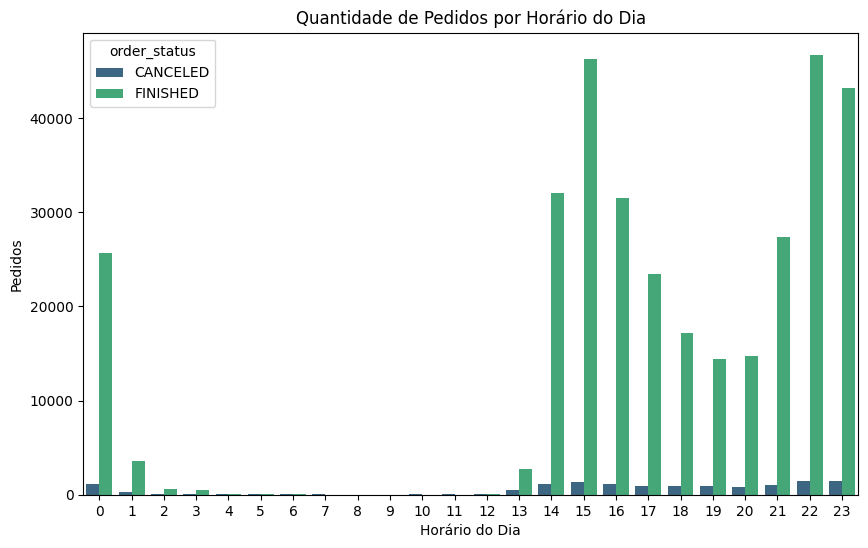

In [8]:
x_plot = 'hour'
plt.figure(figsize=(10,6))
sns.countplot(x=x_plot, data=df_date, palette='viridis', hue='order_status')
plt.xlabel('Horário do Dia')
plt.ylabel('Pedidos')
plt.title('Quantidade de Pedidos por Horário do Dia')
plt.show()

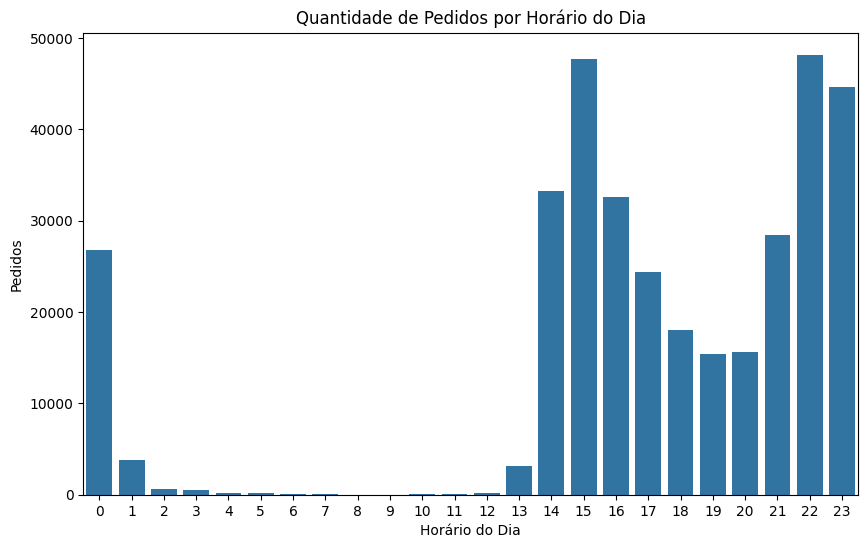

In [9]:
x_plot = 'hour'

plt.figure(figsize=(10,6))
#sns.countplot(x=x_plot, data=df, hue=x_plot, legend=False, palette='viridis')
sns.countplot(x=x_plot, data=df_date)
plt.xlabel('Horário do Dia')
plt.ylabel('Pedidos')
plt.title('Quantidade de Pedidos por Horário do Dia')
plt.show()

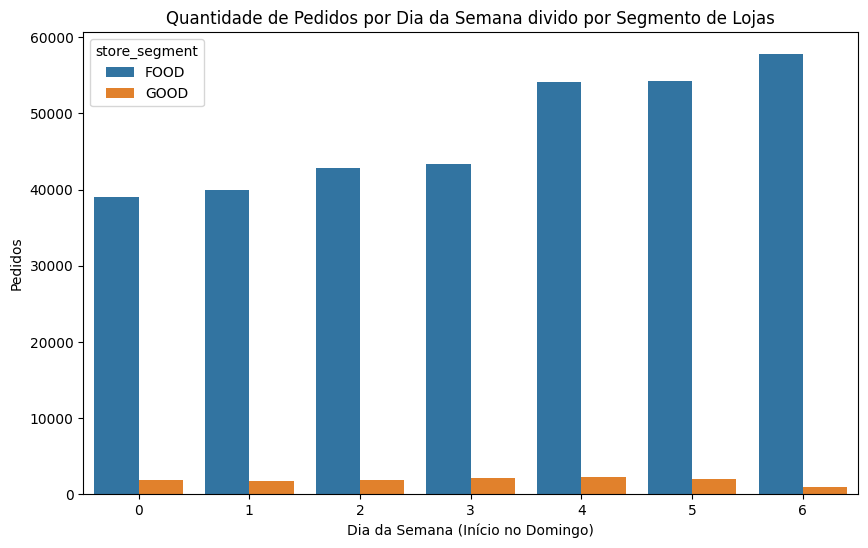

In [10]:
x_plot = 'weekday'

plt.figure(figsize=(10,6))
sns.countplot(x=x_plot, data=df_date, hue='store_segment')
plt.xlabel('Dia da Semana (Início no Domingo)')
plt.ylabel('Pedidos')
plt.title('Quantidade de Pedidos por Dia da Semana divido por Segmento de Lojas')
plt.show()

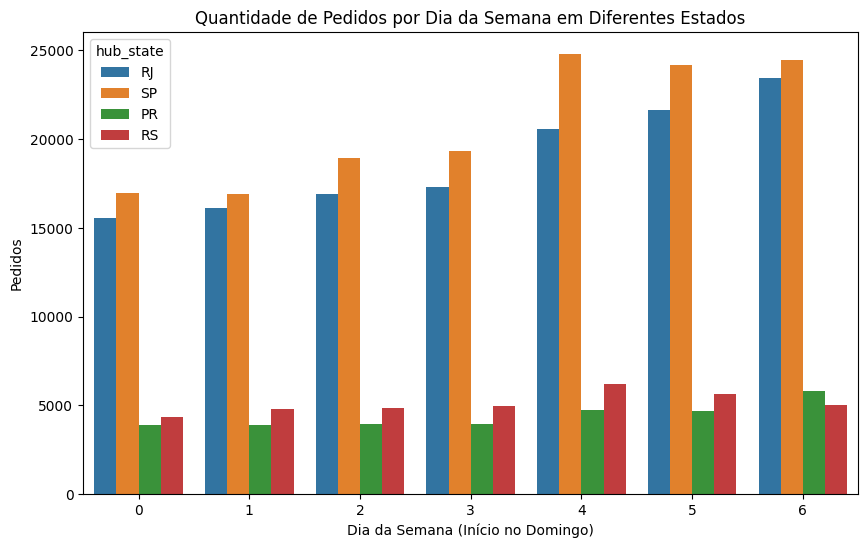

In [11]:
x_plot = 'weekday'

plt.figure(figsize=(10,6))
#sns.countplot(x=x_plot, data=df, hue=x_plot, legend=False, palette='viridis')
sns.countplot(x=x_plot, data=df_date, hue='hub_state')
plt.xlabel('Dia da Semana (Início no Domingo)')
plt.ylabel('Pedidos')
plt.title('Quantidade de Pedidos por Dia da Semana em Diferentes Estados')
plt.show()

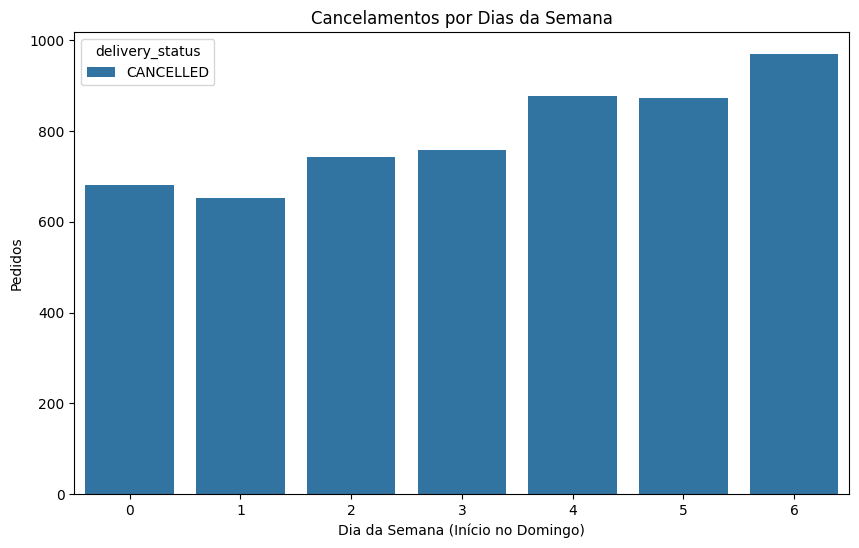

In [12]:
x_plot = 'weekday'

plt.figure(figsize=(10,6))
sns.countplot(x=x_plot, data=df_date[df_date['delivery_status'].eq('CANCELLED')], hue='delivery_status')
plt.xlabel('Dia da Semana (Início no Domingo)')
plt.ylabel('Pedidos')
plt.title('Cancelamentos por Dias da Semana')
plt.show()

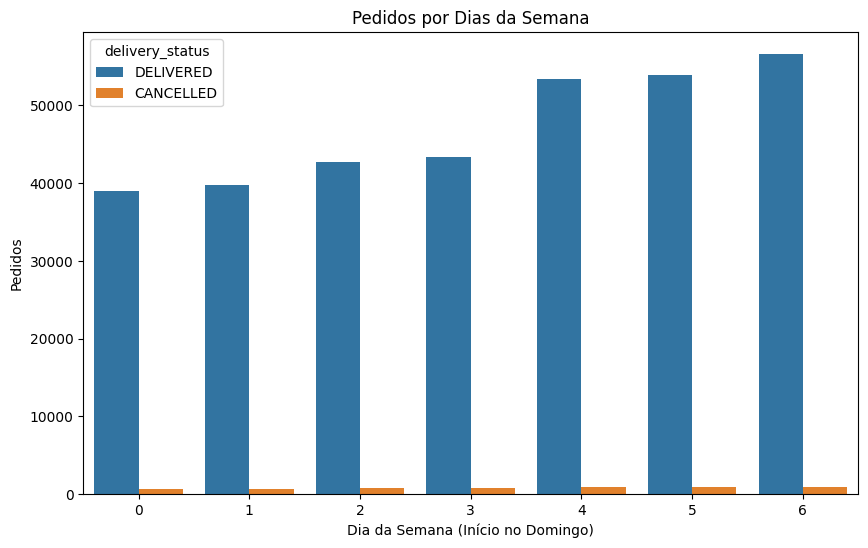

In [13]:
x_plot = 'weekday'

plt.figure(figsize=(10,6))
sns.countplot(x=x_plot, data=df_date[~df_date['delivery_status'].eq('DELIVERING')], hue='delivery_status')
plt.xlabel('Dia da Semana (Início no Domingo)')
plt.ylabel('Pedidos')
plt.title('Pedidos por Dias da Semana')
plt.show()

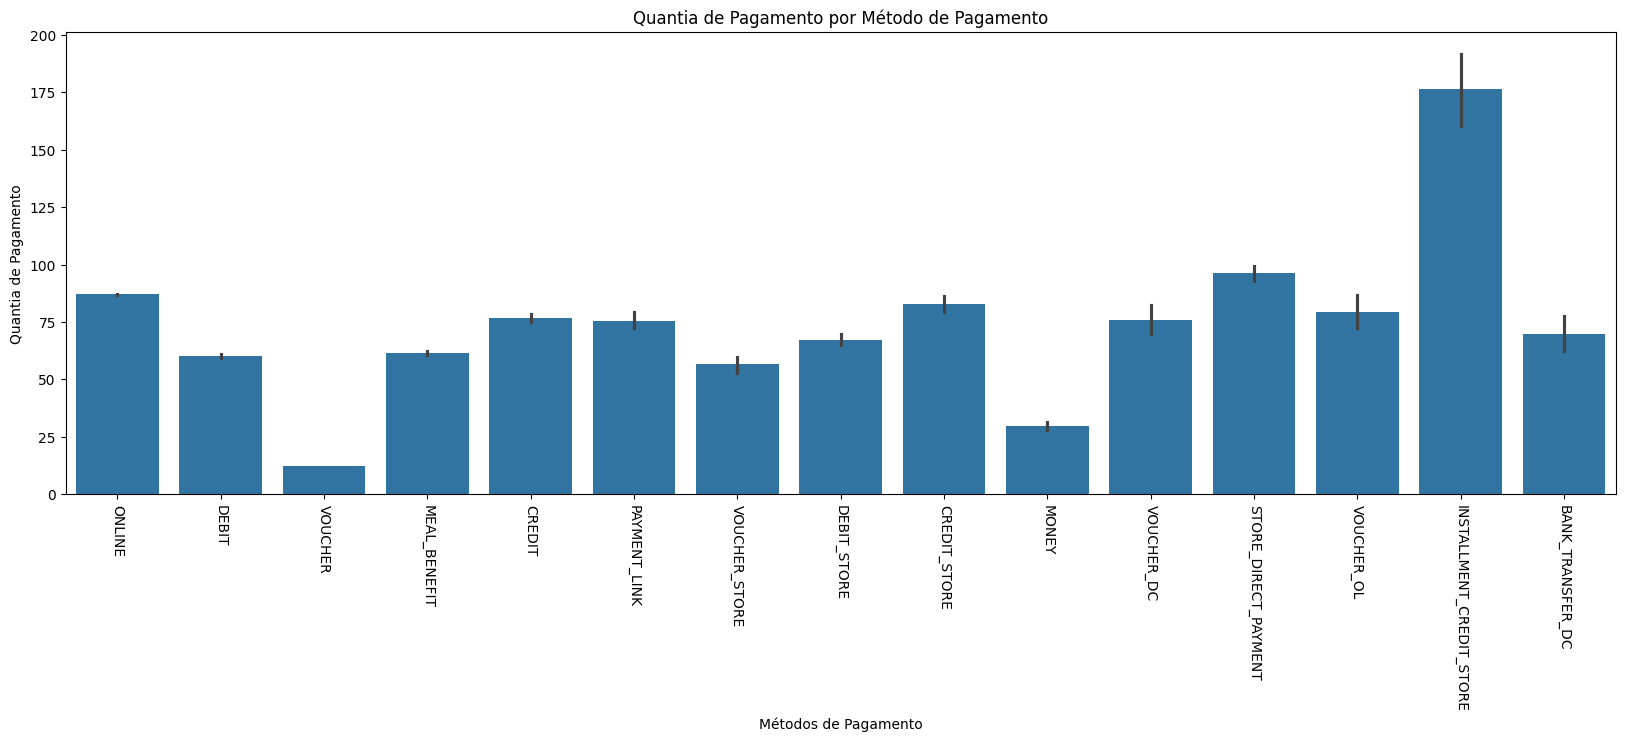

In [14]:
x_plot = 'payment_method'
y_plot = 'payment_amount'

plt.figure(figsize=(20,6))
sns.barplot(x=x_plot, y=y_plot, data=df_date)
plt.xlabel('Métodos de Pagamento')
plt.xticks(rotation=-90)
plt.ylabel('Quantia de Pagamento')
plt.title('Quantia de Pagamento por Método de Pagamento')
plt.show()